# GRAD 5203 Lecture on Machine Learning with Scikit-Learn

## David John Gagne II

*National Center for Atmospheric Research*

November 8, 2016

# About Me

* Advanced Study Program Postdoctoral Fellow at the National Center for Atmospheric Research
* Ph.D. in Meteorology from OU in 2016, M.S. in 2012, B.S. in 2010
* Research Focus: Developing and evaluating machine learning forecast systems for high impact weather 
* Hail and solar energy


# How are data analytics being used in meteorology?
  * Data Mining
    * Discover patterns relating weather data and non-meteorological factors
    * Example: amount of rain vs. election turnout
  * Data Fusion for Nowcasting
    * Merge data from different observation sources (e.g., radar, satellite, surface) 
    * Estimate a weather property of interest
  * Numerical Weather Prediction (NWP) Model Post-Processing
    * Correct for sysematic biases in NWP model output
    * Predict quantities not tracked or resolved by NWP models

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.calibration import calibration_curve
%matplotlib inline

In [2]:
hail_data = pd.read_csv("sars_hail.txt", sep="\t")
print(hail_data.columns)
hail_objects = pd.read_csv("hail_objects.csv")

Index(['DATE/RAOB', ' ELEV', 'REPORT', 'MUCAPE', 'MUMR', '500TEMP', '300 T',
       '7-5LR', '5-3 LR', '0-3SH', '0-6SH', '0-9SH', 'SRH3', 'SHIP', 'MODELb'],
      dtype='object')


In [3]:
hail_objects

,Object,Size
0,Marble/Moth ball,0.50
1,Penny,0.75
2,Nickel,0.88
3,Quarter,1.00
4,Half Dollar,1.25
5,Ping pong,1.50
6,Golf ball,1.75
7,Hen egg/Lime,2.00
8,Tennis ball,2.50
9,Baseball,2.75


## Hail Report Biases
* Reports of hail diameter are collected from the public by the National Weather Service
* Observers are encouraged to measure the diameter of the hail
* But often size is estimated based on comparisons with common objects
* Result: under-reporting of size categories with no object

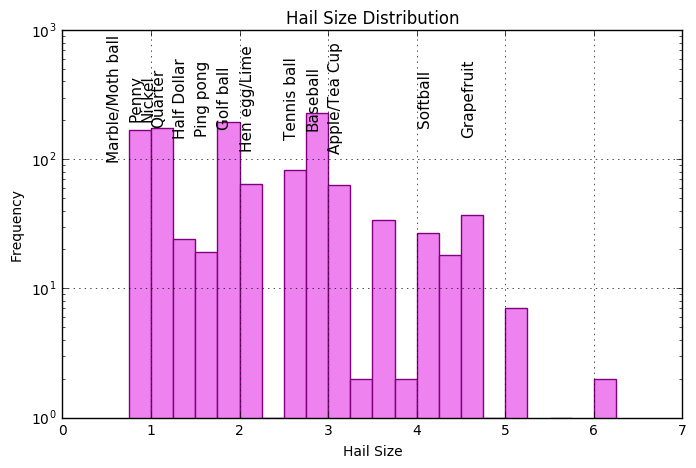

In [4]:
hail_data.hist("REPORT", bins=np.arange(0, 7, 0.25), figsize=(8, 5), color="violet", edgecolor="purple")
plt.xlabel("Hail Size")
plt.ylabel("Frequency")
plt.title("Hail Size Distribution")
for r in hail_objects.index:
    plt.text(hail_objects.loc[r,"Size"], 300, hail_objects.loc[r,"Object"], 
             rotation=90, ha="left", va="center", fontsize=11)
ax = plt.gca()
ax.set_yscale("log")

In [25]:
train = hail_data.sample(frac=0.7, random_state=404)
test = hail_data.drop(train.index)

In [57]:
input_cols = np.array(['MUCAPE', 'MUMR', '500TEMP', '300 T', '7-5LR', '5-3 LR', '0-3SH', '0-6SH', '0-9SH', 'SRH3'])
test_col = "REPORT"
size_threshold = 2
models = [RandomForestClassifier(n_estimators=100, max_features="sqrt"),
         LogisticRegression(penalty="l1")]
model_names = np.array(["Random Forest",
                        "Logistic Regression"])
for model in models:
    model.fit(train[input_cols], np.where(train[test_col] >= size_threshold, 1, 0))


<IPython.core.display.Javascript object>


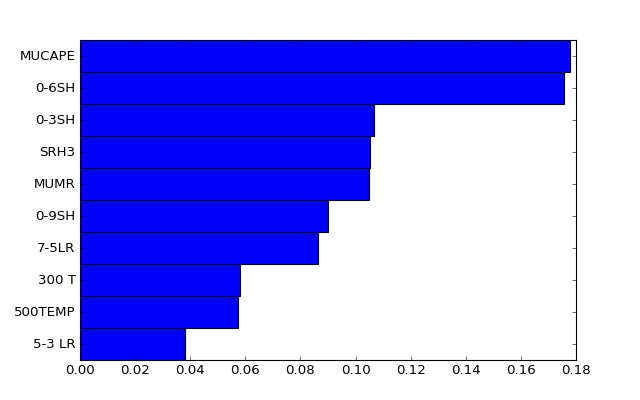

([<matplotlib.axis.YTick at 0x11fb01160>,
 <a list of 10 Text yticklabel objects>)

In [59]:
feature_ranking = models[0].feature_importances_.argsort()
plt.figure(figsize=(8, 5))
plt.barh(np.arange(feature_ranking.size), models[0].feature_importances_[feature_ranking], 1)
plt.yticks(np.arange(feature_ranking.size) + 0.5, input_cols[feature_ranking])

In [63]:
for i, input_name in enumerate(input_cols):
    print(input_name, models[1].coef_[0,i])

MUCAPE 0.0015462859472
MUMR -0.245969563885
500TEMP -0.0531130022316
300 T 0.0215461816882
7-5LR 0.0
5-3 LR -0.0431308166473
0-3SH 0.0916886392176
0-6SH 0.0871946618759
0-9SH 0.0288657931098
SRH3 0.000120168628662


<IPython.core.display.Javascript object>


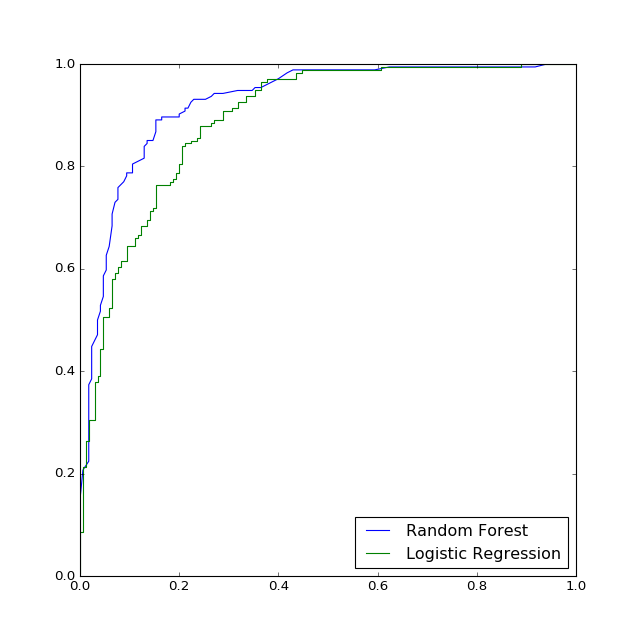

In [60]:
test_results = pd.DataFrame(columns=model_names, index=test.index, dtype=float)
test_labels = np.where(test[test_col] >= size_threshold, 1, 0)
plt.figure(figsize=(8,8))
for m, model in enumerate(models):
    test_results[model_names[m]] = model.predict_proba(test[input_cols])[:, 1]
    pofd, pod, prob_thresh = roc_curve(test_labels, test_results[model_names[m]], pos_label=1)
    plt.plot(pofd, pod, label=model_names[m])
plt.legend(loc=4)
#plt.plot(prob_thresh, pod - pofd)